In [72]:
# load csv

# Read the file to see its structure and check how the tables are separated

import re
import pandas as pd

# def parse_cd_csv(file_path, ):
#     with open(file_path, "r") as file:
#         file_content = file.read()
    
#     # Split the content to find the "Data:" section
#     data_section = file_content.split("Data:\n\n")[1]
    
#     # Split the data section into individual table sections (split by one empty line, accounting for blank lines)
#     tables_raw = re.split(r'\n\n+', data_section.strip())
    
#     # Initialize an empty dictionary to hold the tables
#     tables = {}
    
#     run_df = pd.DataFrame() #columns=['Wavelength', 'Temperature']
#     # Loop through the raw tables and parse them
#     for section in tables_raw:
#         # Adjusting the regex to capture all possible table titles, including CircularDichroism
#         match = re.search(r'(CircularDichroism|HV|Absorbance|Voltage|Count|SE)', section)
#         if match:
#             title = match.group(1)
#             # Split the section into lines
#             lines = section.strip().split('\n')
            
#             # The second line contains the index and column headers (e.g., Wavelength,Temperature)
#             variables = lines[1].split(',')
#             index_column_name = variables[0]
#             assert index_column_name=="Wavelength"
#             variable_column_name = variables[1]

#             # The third line contains the actual column headers (e.g., ,5,10,15,20,...) if Temperature or 0,1,2,3,4.. if Repeat
#             column_headers = lines[2].split(',')

#             # The rest of the lines are data rows
#             data = [line.split(',') for line in lines[3:] if line.strip()]
#             # melt the data
#             # Ensure the number of columns matches, trimming or padding the headers if necessary
#             max_columns = max(len(row) for row in data)
#             adjusted_column_headers = column_headers[:max_columns]
#             if len(adjusted_column_headers) < max_columns:
#                 adjusted_column_headers += [''] * (max_columns - len(adjusted_column_headers))
            
#             # Create a DataFrame
#             df = pd.DataFrame(data, columns=[index_column_name] + adjusted_column_headers[1:])
#             df.set_index(index_and_columns[0], inplace=True)
            
#             # Convert the data to numeric where possible
#             df = df.apply(pd.to_numeric, errors='coerce')
#             df = df.reset_index()  # Wavelength should not be the index
#             df = df.astype(float)  # Set all other columns as float
#             df['Wavelength'] = df['Wavelength'].astype(int)  # Set Wavelength as int


#             # If the table is CircularDichroism, melt the table
#             # if title == "CircularDichroism":
#             df = df.melt(id_vars=["Wavelength"], var_name="Temperature", value_name=title)
#             if run_df.empty:
#                 run_df=df
#             else:
#                 run_df = pd.merge(run_df, df, on=['Wavelength', 'Temperature'])
#     return run_df

import re
import pandas as pd
import re
import pandas as pd

def parse_cd_csv(file_path, temperature_value=None):
    """
    Parses the CD CSV file and dynamically handles 'Temperature' or 'Repeat' columns.
    
    Arguments:
    - file_path: str : Path to the CSV file.
    - temperature_value: float : Required if the structure is based on 'Repeat'. Assigns a constant temperature value for all repeats.
    
    Returns:
    - run_df: DataFrame : Combined and parsed DataFrame from the CSV.
    """
    with open(file_path, "r") as file:
        file_content = file.read()
    
    # Split the content to find the "Data:" section
    data_section = file_content.split("Data:\n\n")[1]
    
    # Split the data section into individual table sections (split by one empty line, accounting for blank lines)
    tables_raw = re.split(r'\n\n+', data_section.strip())
    
    # Initialize an empty DataFrame to hold the processed data
    run_df = pd.DataFrame()
    
    # Loop through the raw tables and parse them
    for section in tables_raw:
        # Adjusting the regex to capture all possible table titles, including CircularDichroism
        match = re.search(r'(CircularDichroism|HV|Absorbance|Voltage|Count|SE)', section)
        if match:
            title = match.group(1)
            # Split the section into lines
            lines = section.strip().split('\n')
            
            # The second line contains the index and column headers (e.g., Wavelength,Temperature or Wavelength,Repeat)
            variables = lines[1].split(',')
            index_column_name = variables[0]
            assert index_column_name == "Wavelength", "The first column must be 'Wavelength'."
            variable_column_name = variables[1]  # Could be Temperature or Repeat
            
            # The third line contains the actual column headers (e.g., ,5,10,15,20,... if Temperature or 0,1,2,3,4.. if Repeat)
            column_headers = lines[2].split(',')

            # The rest of the lines are data rows
            data = [line.split(',') for line in lines[3:] if line.strip()]
            
            # Ensure the number of columns matches, trimming or padding the headers if necessary
            max_columns = max(len(row) for row in data)
            adjusted_column_headers = column_headers[:max_columns]
            if len(adjusted_column_headers) < max_columns:
                adjusted_column_headers += [''] * (max_columns - len(adjusted_column_headers))
            
            # Create a DataFrame from the data
            df = pd.DataFrame(data, columns=[index_column_name] + adjusted_column_headers[1:])
            
            # Convert the data to numeric where possible
            df = df.apply(pd.to_numeric, errors='coerce')
            df = df.reset_index(drop=True)  # Ensure no index from original file
            df['Wavelength'] = df['Wavelength'].astype(int)  # Ensure Wavelength is an integer
            

            # Melt the table to have a long format with "Wavelength", var_name (Temperature/Repeat), and the table title
            df = df.melt(id_vars=["Wavelength"], var_name=variable_column_name, value_name=title)



            # If merging multiple data sections, merge on "Wavelength" and var_name (Temperature or Repeat)
            if run_df.empty:
                run_df = df
            else:
                run_df = pd.merge(run_df, df, on=['Wavelength', variable_column_name], how='outer')
            # Detect whether the structure is Temperature or Repeat
        if "Temperature" == variable_column_name:
            assert temperature_value is None, "temperature_value should not be passed when Temperature column is present."
            var_name = "Temperature"
        else:
            # If Repeat structure, ensure temperature_value is passed
            assert temperature_value is not None, "temperature_value must be provided when using 'Repeat' structure."
            df["Temperature"] = temperature_value  # Assign temperature value to a new Temperature column
            
    return run_df

melt_df = parse_cd_csv(
    "/home/tadas/code/CD_analysis/inputs/deltaprot1_50uM_5C_80Cmelt00002.csv"
)
post_melt_df = parse_cd_csv("/home/tadas/code/CD_analysis/inputs/deltaprot1_50uM_5C_postmelt00000.csv",5)
post_melt_df

,Wavelength,Repeat,CircularDichroism,Temperature,HV,Absorbance,Voltage,Count,SE
0,280,0,0.562020,5,245.575,0.028644,8.06414,10000,0.095569
1,279,0,0.642424,5,245.575,0.029305,8.03380,10000,0.095721
2,278,0,0.660523,5,245.575,0.027003,8.03605,10000,0.079906
3,277,0,0.633973,5,245.575,0.029146,7.99234,10000,0.090648
4,276,0,0.440982,5,245.575,0.031977,7.93755,10000,0.094461
...,...,...,...,...,...,...,...,...,...
399,184,3,31.933300,5,431.625,1.626020,8.04797,10000,0.483656
400,183,3,28.488900,5,454.590,1.735060,8.06628,10000,0.568174
401,182,3,26.993500,5,493.988,1.906190,8.02808,10000,0.796221
402,181,3,22.633000,5,564.545,2.169520,7.90226,10000,0.934408


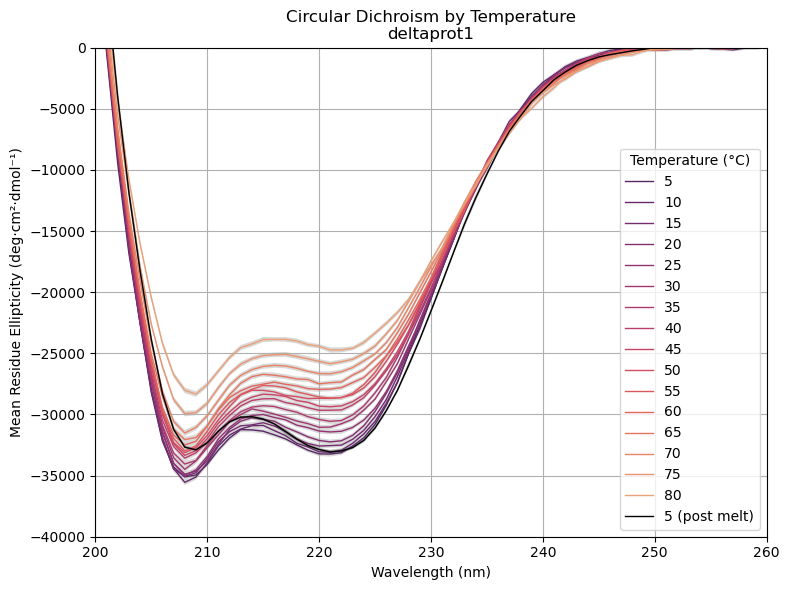

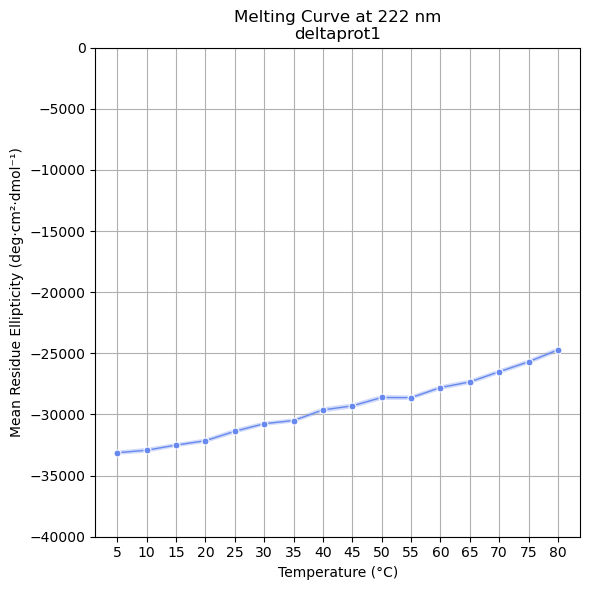

In [77]:
import os
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Set seaborn color palette to 'flare_r'


def get_mean_residue_ellipticity(protein_concentration_uM=50, path_length_mm=0.5, num_residues=33):
    # Convert Path Length from mm to cm and Protein Concentration from µM to M
    path_length_cm = path_length_mm / 10  # 1 cm = 10 mm
    concentration_M = protein_concentration_uM * 1e-6  # Convert µM to M
    # Calculate MRE multiplication factor
    return 1 / (10 * path_length_cm * num_residues * concentration_M)

def smooth_cd_data(cd_data, column_name='CircularDichroism', weight_col='Weight', window_size=3):
    cd_data[weight_col] = 1 / (cd_data['SE'] + 0.0001)  # Weight to avoid division by zero
    smoothed = np.convolve(cd_data[column_name] * cd_data[weight_col], np.ones(window_size) / window_size, mode='same')
    weight_sum = np.convolve(cd_data[weight_col], np.ones(window_size) / window_size, mode='same')
    return smoothed / weight_sum

def prepare_cd_data(cd_data, protein_concentration_uM=50, path_length_mm=0.5, num_residues=33):
    mre_factor = get_mean_residue_ellipticity(protein_concentration_uM, path_length_mm, num_residues)
    cd_data['Smoothed_CD'] = smooth_cd_data(cd_data)
    cd_data['MRE_deg_cm2_dmol'] = cd_data['Smoothed_CD'] * mre_factor
    cd_data['SE_MRE_deg_cm2_dmol'] = cd_data['SE'] * mre_factor
    return cd_data

def plot_cd_melt(cd_filtered, label_suffix='', line_width=1):
    # Use Seaborn's built-in error plotting
    sns.lineplot(
        data=cd_filtered,
        x='Wavelength',
        y='MRE_deg_cm2_dmol',
        hue='Temperature',
        palette='flare_r',  # Automatically handles color mapping for temperatures
        linewidth=line_width,
        legend='full',
    )
    
    # Use fill_between to plot the error manually
    plt.fill_between(
        cd_filtered['Wavelength'],
        cd_filtered['MRE_deg_cm2_dmol'] - cd_filtered['SE_MRE_deg_cm2_dmol'],
        cd_filtered['MRE_deg_cm2_dmol'] + cd_filtered['SE_MRE_deg_cm2_dmol'],
        alpha=0.3,
        color="grey",
        edgecolor=None
    )

def plot_cd_melt_data(cd_data, sample_name, overlay_cd_data=None, overlay_label="Overlay",
                      title="Circular Dichroism by Temperature", save_dir="."):
    # Prepare CD data
    cd_data = prepare_cd_data(cd_data)

    # Set limits for the plot
    x_limits = (200, 260)
    y_limits = (-40000, 1)

    # Filter the data for the relevant wavelength range
    cd_filtered = cd_data[(cd_data['Wavelength'] >= x_limits[0]) & (cd_data['Wavelength'] <= x_limits[1])]

    # Plot the data
    plt.figure(figsize=(8, 6))
    plot_cd_melt(cd_filtered, line_width=1)  # Use a thinner line

    # Check if there is overlay data to plot
    if overlay_cd_data is not None:
        overlay_cd_data = prepare_cd_data(overlay_cd_data)
        overlay_cd_filtered = overlay_cd_data[(overlay_cd_data['Wavelength'] >= x_limits[0]) & 
                                              (overlay_cd_data['Wavelength'] <= x_limits[1])]
        
        # Overlay the error area for the overlay data
        # plt.fill_between(
        #     overlay_cd_filtered['Wavelength'],
        #     overlay_cd_filtered['MRE_deg_cm2_dmol'] - overlay_cd_filtered['SE_MRE_deg_cm2_dmol'],
        #     overlay_cd_filtered['MRE_deg_cm2_dmol'] + overlay_cd_filtered['SE_MRE_deg_cm2_dmol'],
        #     alpha=0.3,
        #     color='gray',
        #     edgecolor=None
        # )    
        sns.lineplot(
            data=overlay_cd_filtered,
            x='Wavelength',
            y='MRE_deg_cm2_dmol',
            color='black',
            label=f'{overlay_label}',
            linewidth=1,
        )



    # Customize the plot
    title+=f"\n{sample_name}"
    plt.title(title)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel("Mean Residue Ellipticity (deg·cm²·dmol⁻¹)")
    plt.xlim(x_limits)
    plt.ylim(y_limits)
    plt.grid(True)
    plt.legend(title='Temperature (°C)', loc='best')

    # Save the plot
    filename = f"cd_melts_{sample_name}"
    if overlay_cd_data is not None:
        filename += "_overlay"
    for ext in ["png", "svg"]:
        plt.savefig(os.path.join(save_dir, f"{filename}.{ext}"), dpi=300, bbox_inches="tight")

    plt.tight_layout()
    plt.show()

# Example call to plotting function

def plot_melting_curve(cd_data, sample_name, title="Melting Curve at 222 nm", save_dir="."):
    # Prepare data
    cd_data['Smoothed_CD'] = smooth_cd_data(cd_data)
    cd_data['MRE_deg_cm2_dmol'] = cd_data['Smoothed_CD'] * get_mean_residue_ellipticity()
    cd_data['SE_MRE_deg_cm2_dmol'] = cd_data['SE'] * get_mean_residue_ellipticity()

    # Filter the data for Wavelength = 222 nm
    melting_data = cd_data[cd_data['Wavelength'] == 222.0]

    # Set up the plot for the melting curve
    plt.figure(figsize=(6, 6))
    # Plot the error area using fill_between
    plt.fill_between(melting_data['Temperature'],
                     melting_data['MRE_deg_cm2_dmol'] - melting_data['SE_MRE_deg_cm2_dmol'],
                     melting_data['MRE_deg_cm2_dmol'] + melting_data['SE_MRE_deg_cm2_dmol'],
                     alpha=0.3,edgecolor=None)  # Transparency for the shaded error area
    sns.lineplot(data=melting_data, x='Temperature', y='MRE_deg_cm2_dmol', marker='o', linewidth=1, markersize=5, legend=False,)  # Thinner line, smaller markers



    # Customize the plot
    title+=f"\n{sample_name}"
    plt.title(title)
    plt.xlabel('Temperature (°C)')
    plt.ylabel("Mean Residue Ellipticity (deg·cm²·dmol⁻¹)")
    plt.grid(True)
    plt.tight_layout()

    y_limits = (-40000, 1)
    plt.ylim(y_limits)

    # Save the plot
    for ext in ["png", "svg"]:
        plt.savefig(os.path.join(save_dir, f"melting_curve_{sample_name}.{ext}"), dpi=300, bbox_inches="tight")

    plt.show()

melt_df = parse_cd_csv(
    "/home/tadas/code/CD_analysis/inputs/deltaprot1_50uM_5C_80Cmelt00002.csv"
)
post_melt_df = parse_cd_csv("/home/tadas/code/CD_analysis/inputs/deltaprot1_50uM_5C_postmelt00000.csv",temperature_value=5)
plot_cd_melt_data(melt_df, sample_name="deltaprot1", overlay_label="5 (post melt)", overlay_cd_data=post_melt_df,save_dir="outputs")
# plot_cd_melt_data(melt_df, sample_name="deltaprot1",save_dir="outputs")
plot_melting_curve(melt_df, sample_name="deltaprot1",save_dir="outputs")

In [57]:
post_melt_df

,Wavelength,Temperature,CircularDichroism,HV,Absorbance,Voltage,Count,SE,Weight,Smoothed_CD,MRE_deg_cm2_dmol,SE_MRE_deg_cm2_dmol
0,280,0,0.562020,245.575,0.028644,8.06414,10000.0,0.095569,10.452663,0.602190,729.927584,115.841697
1,279,0,0.642424,245.575,0.029305,8.03380,10000.0,0.095721,10.436169,0.624028,756.397111,116.024970
2,278,0,0.660523,245.575,0.027003,8.03605,10000.0,0.079906,12.499031,0.646344,783.446982,96.856000
3,277,0,0.633973,245.575,0.029146,7.99234,10000.0,0.090648,11.019490,0.583844,707.690084,109.876727
4,276,0,0.440982,245.575,0.031977,7.93755,10000.0,0.094461,10.575229,0.535212,648.741809,114.497697
...,...,...,...,...,...,...,...,...,...,...,...,...
399,184,3,31.933300,431.625,1.626020,8.04797,10000.0,0.483656,2.067158,32.847864,39815.592383,586.249697
400,183,3,28.488900,454.590,1.735060,8.06628,10000.0,0.568174,1.759715,29.520298,35782.179441,688.695758
401,182,3,26.993500,493.988,1.906190,8.02808,10000.0,0.796221,1.255775,26.495500,32115.757546,965.116364
402,181,3,22.633000,564.545,2.169520,7.90226,10000.0,0.934408,1.070082,24.214554,29350.974308,1132.615758
